In [23]:
import copy
import tqdm
import os
import numpy as np
import torchio as tio
import cv2
import matplotlib.pyplot as plt
import argparse

def get_colored_image(image, color_map=None):
    # Define the default color map
    if color_map is None:
        color_map = {
            0: [0, 0, 0],  # Black (TN)
            1: [1, 0, 0],  # Red (FP) (pred only)
            2: [0, 0, 1],  # Blue (FN) (double_mask only)
            3: [0, 1, 0],  # Green (TP)
        }
    # Create an empty RGB image
    if len(image.shape) < 3:
        height, width = image.shape[0], image.shape[1]
        colored_image = np.zeros((height, width, 3), dtype=np.float32) 
    else:
        depth, height, width = image.shape[0], image.shape[1], image.shape[2]
        colored_image = np.zeros((depth, height, width, 3), dtype=np.float32) 
    
    # Map the pixel values to the corresponding colors
    for value, color in color_map.items():
        colored_image[image == value] = color
    return colored_image

def assemble_predictions(images_dir, preds_dir, gt_dir, start_s=0, start_y=0, start_x=0, end_s=6, end_y=8192, end_x=9216):
    tile_depth=3
    tile_width=512
    tile_height=512
    total_slices = ((end_s//tile_depth) * ((end_y-start_y)//tile_height )* ((end_x-start_x)//tile_width))
    slice_num = 0
    print(total_slices, "total slices")
    for s in range(start_s, end_s, 3):
        s_acc_img, s_acc_pred, s_acc_gt = [], [], []
        for y in range(start_y, end_y, 512):
            y_acc_img, y_acc_pred, y_acc_gt = [], [], []
            for x in range(start_x, end_x, 512):
                print(f"Processing volume {s,y,x} | Progress:{slice_num+1}/{total_slices} {(slice_num)/total_slices}", end="\r")
                suffix = r"z{}_y{}_x{}".format(s, y, x)
                
                # load img
                try:
                    img_vol = np.load(os.path.join(images_dir, f"{suffix}.npy"))
                except:
                    img_vol = np.zeros((3, 512,512))
                    print("no img")
                d, h, w = img_vol.shape
                if (d < tile_depth) or (h < tile_height) or (w < tile_width):
                    print("cropping since imgvol shape:", img_vol.shape)
                    img_vol = tio.CropOrPad((tile_depth, tile_height, tile_width))(torch.tensor(img_vol).unsqueeze(0))
                
                # load gt
                try:
                    gt_vol = np.load(os.path.join(gt_dir, f"{suffix}.npy"))
                except:
                    gt_vol = np.zeros((3,512,512))
                    print("no gt")
                if (d < tile_depth) or (h < tile_height) or (w< tile_width):
                    gt_vol = tio.CropOrPad((tile_depth, tile_height, tile_width))(gt_vol)
                
                # load pred
                try:
                    pred_vol = np.load(os.path.join(preds_dir, f"{suffix}.npy"))
                    pred_vol = np.argmax(pred_vol[0], 0) 
                except:
                    print("no pred vol")
                    pred_vol = np.zeros((3, 512,512))
                if (d < tile_depth) or (h < tile_height) or (w < tile_width):
                    pred_vol = tio.CropOrPad((tile_depth, tile_height, tile_width))(pred_vol)
                    
                small_3d_img = []
                small_3d_pred = []
                small_3d_gt = []
                for k in range(3):
                    img = img_vol[k]
                    gt = gt_vol[k]
                    pred = pred_vol[k]
                    small_3d_img += [img]
                    small_3d_gt += [gt]
                    small_3d_pred += [pred]
                    
                small_3d_pred = np.array(small_3d_pred) # (tile depth, tile height, tile width)
                small_3d_gt = np.array(small_3d_gt)
                small_3d_img = np.array(small_3d_img)
                    
                y_acc_gt += [small_3d_gt]
                y_acc_img += [small_3d_img]
                y_acc_pred += [small_3d_pred]
                slice_num+=1
            print(f"Processing volume {s,y,x} | Progress:{slice_num+1}/{total_slices} {(slice_num)/total_slices}")
            s_acc_img += [np.concatenate(y_acc_img, axis=2)]
            s_acc_pred += [np.concatenate(y_acc_pred, axis=2)]
            s_acc_gt += [np.concatenate(y_acc_gt, axis=2)]

        new_img = np.concatenate(s_acc_img, axis=1)
        new_pred = np.concatenate(s_acc_pred, axis=1)
        new_gt = np.concatenate(s_acc_gt, axis=1)
        
        return new_img, new_pred, new_gt
    
def assemble_predictions_2d(images_dir, preds_dir, gt_dir, s=0, slice_depth=0, start_y=0, start_x=0, end_y=8192, end_x=9216):
    print(f"Assembling s{s}, slicedepth{slice_depth}")
    tile_width=512
    tile_height=512
    total_slices = ((end_y-start_y)//tile_height )* ((end_x-start_x)//tile_width)
    slice_num = 0
    s_acc_img, s_acc_pred, s_acc_gt = [], [], []
    for y in range(start_y, end_y, 512):
        y_acc_img, y_acc_pred, y_acc_gt = [], [], [] # (512, entire width)
        for x in range(start_x, end_x, 512):
            print(f"Processing volume {s,y,x} | Progress:{slice_num+1}/{total_slices} {(slice_num)/total_slices}", end="\r")
            pred_suffix= r"z{}_y{}_x{}_{}".format(s, y, x, slice_depth)
            suffix = r"z{}_y{}_x{}".format(s, y, x)
            
            # get pred
            fp=os.path.join(preds_dir, f"{pred_suffix}.png")
            pred = cv2.imread(fp, cv2.COLOR_BGR2GRAY)
            pred[pred!=0]=1

            # get mask
            mask_fp=os.path.join(gt_dir, f"{suffix}.npy")
            mask = np.load(mask_fp)
            mask = mask[slice_depth]

            # get mask
            img_fp=os.path.join(images_dir, f"{suffix}.npy")
            img = np.load(img_fp)
            img = img[slice_depth]
                
            y_acc_gt += [mask]
            y_acc_img += [img]
            y_acc_pred += [pred]
            slice_num+=1
        print(f"Processing volume {s,y,x} | Progress:{slice_num+1}/{total_slices} {(slice_num)/total_slices}")
        s_acc_img += [np.concatenate(y_acc_img, axis=1)] # (entire height, entire width)
        s_acc_pred += [np.concatenate(y_acc_pred, axis=1)]
        s_acc_gt += [np.concatenate(y_acc_gt, axis=1)]
        
    new_img = np.concatenate(s_acc_img, axis=0)
    new_pred = np.concatenate(s_acc_pred, axis=0)
    new_gt = np.concatenate(s_acc_gt, axis=0)
    
    return new_img, new_pred, new_gt
    

# 2d

In [35]:
comb_dir="/Users/huayinluo/100_110_model_job132/combinedpreds/"

In [13]:
for tmpfp in os.listdir(comb_dir):
    tmp=cv2.imread(comb_dir + tmpfp)
    nums, vals=np.unique(tmp, return_counts=True)
    if len(nums) > 1:
        print(nums, vals)
        break

[0 1] [785322   1110]


(512, 512, 3)


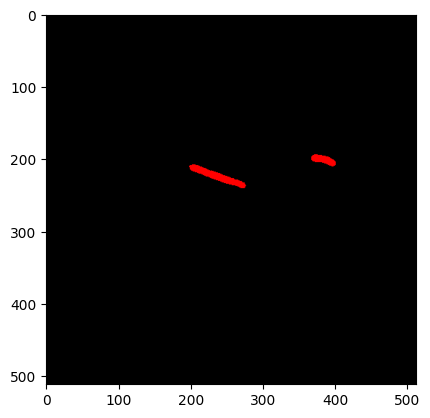

In [15]:
print(tmp.shape)
tmp[tmp!=0]=255
plt.imshow(tmp)

In [24]:
# pred_dir="/Users/huayinluo/100_110_model_job132/binarypreds"
# pred_dir="/Volumes/LaCie/100_110_model_job111/binarypreds"
# mask_dir="/Volumes/LaCie/zhenlab/gjsegmentation/gj_test_datasets/100_110_3x512x512/ground_truth"
# img_dir="/Volumes/LaCie/zhenlab/gjsegmentation/gj_test_datasets/100_110_3x512x512/original"

pred_dir="/Volumes/LaCie/111_120_model_job138b_epoch_74/binarypreds"
mask_dir="/Volumes/LaCie/111_120_3x512x512_no_overlap/ground_truth"
img_dir="/Volumes/LaCie/111_120_3x512x512_no_overlap/original"
save_dir="/Volumes/LaCie/111_120_model_job138b_epoch_74_vis"


# pred_dir="/Volumes/LaCie/0_50_model_job138b_epoch_74/binarypreds"
# mask_dir="/Volumes/LaCie/filtered_0_50_3x512x512/ground_truth"
# img_dir="/Volumes/LaCie/filtered_0_50_3x512x512/original"
# save_dir="/Volumes/LaCie/0_50_model_job138b_epoch_74_vis"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    print("made save dir", save_dir)

In [25]:
# Save 1 slice
import time
start_x, end_x = 1536, 7168
start_y, end_y = 1536, 6656
alpha=0.4
show_img=True
prefix="0_50_"
threshold_confidence = 9 # (only keep confidence 4 and 5)
s=0
for slice_depth in range(0, 3):
    start = time.time()
    new_img, new_pred, new_gt = assemble_predictions_2d(img_dir, pred_dir, mask_dir, start_x=start_x,end_x=end_x,start_y=start_y,end_y=end_y,s=s, slice_depth=slice_depth)
    print(time.time()-start)
    print("shape", new_img.shape, new_pred.shape, new_gt.shape)
    cv2.imwrite(os.path.join(save_dir, f"{prefix}pred_slice{s}_{slice_depth}.png"),new_pred)
    print("Saved pred")
    binary_mask = new_gt.copy()
    print(np.unique(binary_mask, return_counts=True))
    binary_mask[binary_mask!=0]=1
    # binary_mask[binary_mask == 2] = 1 # keep muscle-muscle gj
    # binary_mask[binary_mask < threshold_confidence] = 0 # 
    # binary_mask[binary_mask >= threshold_confidence] = 1
    combined_volume = np.asarray((binary_mask * 2 + new_pred))
    vals, counts = np.unique(combined_volume, return_counts=True)
    color_combined_volume = get_colored_image(combined_volume)
    res = dict(map(lambda i,j : (int(i),j) , vals,counts))
    fp = res.get(1, 0)
    fn = res.get(2, 0)
    tp = res.get(3, 0)
    precision = tp/(tp+fp) if (tp+fp)!=0 else 0
    recall = tp/(tp+fn) if (tp+fn)!=0 else 0
    print(precision, recall)
    if show_img:
        plt.imshow(new_img, cmap='gray', alpha=alpha)
        plt.imshow(color_combined_volume)
    else:
        plt.imshow(color_combined_volume)
    plt.savefig(os.path.join(save_dir, f"{prefix}comb_slice{s}_{slice_depth}.png"), dpi=800)
    print("Saved comb")

Assembling s0, slicedepth0


[ WARN:0@10371.125] global loadsave.cpp:248 findDecoder imread_('/Volumes/LaCie/0_50_model_job138b_epoch_74/binarypreds/z0_y1536_x1536_0.png'): can't open/read file: check file path/integrity


TypeError: 'NoneType' object does not support item assignment

showing img
(5120, 5632) (5120, 5632, 3)
Saved comb


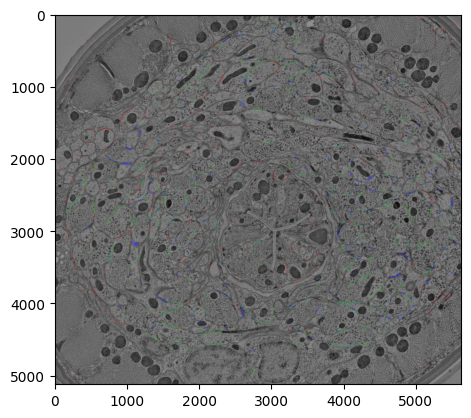

In [19]:
if show_img:
    print("showing img")
    print(new_img.shape, color_combined_volume.shape)
    plt.imshow(new_img, cmap='gray')
    plt.imshow(color_combined_volume, alpha=alpha)
else:
    plt.imshow(color_combined_volume)
plt.savefig(os.path.join(save_dir, f"{prefix}comb_slice{s}_{slice_depth}.png"), dpi=800)
print("Saved comb")

In [14]:
# Save all slice
import time
start_x, end_x = 1536, 7168
start_y, end_y = 1536, 6656
prefix="conf_above_9_"
threshold_confidence = 9 # (only keep confidence 4 and 5)
for s in range(0, 10, 3):
    for slice_depth in range(0, 3):
        start = time.time()
        new_img, new_pred, new_gt = assemble_predictions_2d(img_dir, pred_dir, mask_dir, start_x=start_x,end_x=end_x,start_y=start_y,end_y=end_y,s=s, slice_depth=slice_depth)
        print(time.time()-start)
        print("shape", new_img.shape, new_pred.shape, new_gt.shape)
        cv2.imwrite(os.path.join(save_dir, f"{prefix}pred_slice{s}_{slice_depth}.png"),new_pred)
        print("Saved pred")
        binary_mask = new_gt.copy()
        print(np.unique(binary_mask), return_counts=True)
        # binary_mask[binary_mask!=0]=1
        binary_mask[binary_mask == 2] = 1 # keep muscle-muscle gj
        binary_mask[binary_mask < threshold_confidence] = 0 # 
        binary_mask[binary_mask >= threshold_confidence] = 1
        combined_volume = np.asarray((binary_mask * 2 + new_pred))
        vals, counts = np.unique(combined_volume, return_counts=True)
        color_combined_volume = get_colored_image(combined_volume)
        res = dict(map(lambda i,j : (int(i),j) , vals,counts))
        fp = res.get(1, 0)
        fn = res.get(2, 0)
        tp = res.get(3, 0)
        precision = tp/(tp+fp) if (tp+fp)!=0 else 0
        recall = tp/(tp+fn) if (tp+fn)!=0 else 0
        print(precision, recall)
        plt.imshow(color_combined_volume)
        plt.savefig(os.path.join(save_dir, f"{prefix}comb_slice{s}_{slice_depth}.png"), dpi=800)
        print("Saved comb")

Assembling s0, slicedepth0
Processing volume (0, 1536, 6656) | Progress:12/110 0.19090909090909091
Processing volume (0, 2048, 6656) | Progress:23/110 0.29090909090909092
Processing volume (0, 2560, 6656) | Progress:34/110 0.39090909090909095
Processing volume (0, 3072, 6656) | Progress:45/110 0.49090909090909093
Processing volume (0, 3584, 6656) | Progress:56/110 0.59090909090909093
Processing volume (0, 4096, 6656) | Progress:67/110 0.6909090909090909
Processing volume (0, 4608, 6656) | Progress:78/110 0.7909090909090909
Processing volume (0, 5120, 6656) | Progress:89/110 0.8909090909090909
Processing volume (0, 5632, 6656) | Progress:100/110 0.909090909090909
Processing volume (0, 6144, 6656) | Progress:111/110 1.0909090909090918
33.86961102485657
shape (5120, 5632) (5120, 5632) (5120, 5632)
Saved pred


TypeError: 'return_counts' is an invalid keyword argument for print()

## testing

In [57]:
import os
s,y,x=0,5632,4608
depth = 0 # (0, 1, or 2)
vol_depth=512

# get pred
suffix = r"z{}_y{}_x{}_{}".format(s, y, x, depth)
fp=os.path.join(pred_dir, f"{suffix}.png")
pred = cv2.imread(fp, cv2.COLOR_BGR2GRAY)
pred[pred!=0]=1
print("loaded pred")

# get mask
suffix = r"z{}_y{}_x{}".format(s+(vol_depth*depth), y, x)
mask_fp=os.path.join(mask_dir, f"{suffix}.npy")
mask = np.load(mask_fp)
mask = mask[depth]
binary_mask = mask.copy()
binary_mask[mask!=0]=1
print("loaded mask")

# get mask
img_fp=os.path.join(img_dir, f"{suffix}.npy")
img = np.load(img_fp)
img = img[depth]
print("loaded img")

loaded pred
loaded mask
loaded img


In [59]:
combined_volume = np.asarray((binary_mask * 2 + pred))
vals, counts = np.unique(combined_volume, return_counts=True)
tn, fp, fn, tp = counts
precision = tp/(tp+fp)
recall = tp/(tp+fn)
print(precision, recall)

0.8302134646962234 0.41599473424387035


In [60]:
color_combined_volume = get_colored_image(combined_volume)

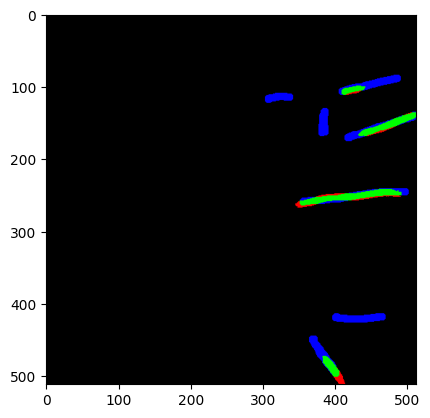

In [54]:
plt.imshow(color_combined_volume)
plt.savefig(os.path.join(save_dir, f"comb_slice{s}.png"))

In [2]:
import os

# 3D

In [3]:
# parser = argparse.ArgumentParser(description="Get evaluation metrics for the model")
# parser.add_argument("--save_dir", type=str, required=True, help="Path to the model file")
# parser.add_argument("--data_dir", type=str, required=True, help="Path to the data directory")
# parser.add_argument("--use_lines", type=bool, default=False, help="Path to the results directory")
# parser.add_argument("--show_img", type=bool, default=False, help="Whether this is train, test, or valid folder")
# parser.add_argument("--alpha", type=float, default=0.4, help="Whether this is train, test, or valid folder")
# parser.add_argument("--line_width", type=int, default=3, help="Whether this is train, test, or valid folder")
# args = parser.parse_args()
# constants
data_dir="/Volumes/LaCie/getpreds1072dtmp/binarypreds/"
save_dir="/Volumes/LaCie/savetmp2/"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
# img_dir=os.path.join(data_dir, "original")
# gt_dir=os.path.join(data_dir, "ground_truth")
# img_dir="/Volumes/LaCie/zhenlab/gjsegmentation/gj_test_datasets/100_110_3x512x512/original"
# gt_dir="/Volumes/LaCie/zhenlab/gjsegmentation/gj_test_datasets/100_110_3x512x512/ground_truth"
img_dir="/Volumes/LaCie/111_120_3x512x512_no_overlap/original"
gt_dir="/Volumes/LaCie/111_120_3x512x512_no_overlap/ground_truth"
pred_dir=os.path.join(data_dir, "pred")
use_lines = True
show_img = True
alpha = 0.4
line_width = 2
yellow = [255, 255, 0]
print(data_dir)
print(save_dir)
print("showimg", show_img)
print("uselines", use_lines)

/Volumes/LaCie/getpreds1072dtmp/binarypreds/
/Volumes/LaCie/savetmp2/
showimg True
uselines True


(array([0], dtype=uint8), array([786432]))


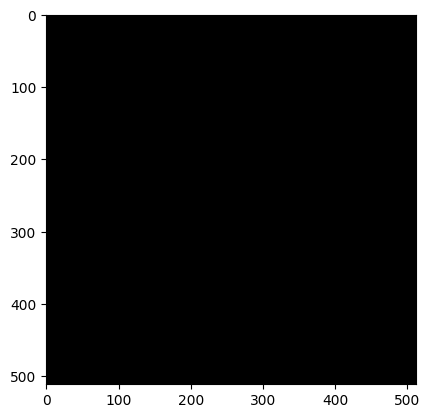

In [10]:
import os
fp="/Volumes/LaCie/getpreds1072dtmp/probpreds/z0_y3072_x3584.npy"
img = cv2.imread(fp)
print(np.unique(img, return_counts=True))
plt.imshow(img)

In [6]:
# stich together preds
import time
start = time.time()
start_x, end_x = 1024, 8192
start_y, end_y = 1536, 6656
start_z, end_z = 0, 3
new_img, new_pred, new_gt = assemble_predictions(img_dir, pred_dir, gt_dir, start_x=start_x,end_x=end_x,start_y=start_y,end_y=end_y,start_s=start_z,end_s=end_z)
print(time.time()-start)
volume_depth = new_img.shape[0]
print("shape", new_img.shape, new_pred.shape, new_gt.shape)

140 total slices
no pred volvolume (0, 1536, 1024) | Progress:1/140 0.0
no pred volvolume (0, 1536, 1536) | Progress:2/140 0.007142857142857143
no pred volvolume (0, 1536, 2048) | Progress:3/140 0.014285714285714285
no pred volvolume (0, 1536, 2560) | Progress:4/140 0.02142857142857143
no pred volvolume (0, 1536, 3072) | Progress:5/140 0.02857142857142857
no pred volvolume (0, 1536, 3584) | Progress:6/140 0.03571428571428571
no pred volvolume (0, 1536, 4096) | Progress:7/140 0.04285714285714286
no pred volvolume (0, 1536, 4608) | Progress:8/140 0.05
no pred volvolume (0, 1536, 5120) | Progress:9/140 0.05714285714285714
no pred volvolume (0, 1536, 5632) | Progress:10/140 0.06428571428571428
no pred volvolume (0, 1536, 6144) | Progress:11/140 0.07142857142857142
no pred volvolume (0, 1536, 6656) | Progress:12/140 0.07857142857142857
no pred volvolume (0, 1536, 7168) | Progress:13/140 0.08571428571428572
no pred volvolume (0, 1536, 7680) | Progress:14/140 0.09285714285714286
Processing vo

In [7]:
unique_gt_labels, unique_gt_counts = np.unique(new_gt, return_counts=True)
print(unique_gt_labels, unique_gt_counts)

[ 0.  2.  3.  5.  7.  9. 11. 15.] [108805128    108661      5277     32017     90160    274910    740846
     43481]


In [12]:
binary_gt=new_gt.copy()
binary_gt[binary_gt!=0]=1

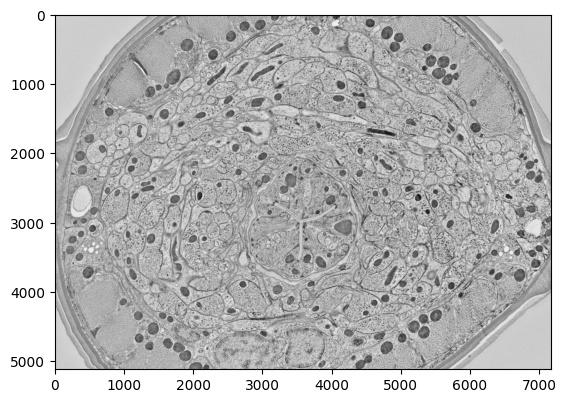

In [13]:
plt.imshow(binary_gt[0], cmap="gray")
plt.imshow(new_img[0], cmap="gray")
plt.show()

In [11]:
# save by confidence
height, width = new_img.shape[1], new_img.shape[2]
binary_gt = new_gt.copy()
label="all_with_muscle_justpred"
binary_gt[binary_gt != 0] = 1 # all labels are positive labels
combined_volume = np.asarray((binary_gt * 2 + new_pred))
print(np.unique(combined_volume, return_counts=True))
print(np.unique(combined_volume[0], return_counts=True))
print(np.unique(combined_volume[1], return_counts=True))
print(np.unique(combined_volume[2], return_counts=True))
color_combined_volume = get_colored_image(combined_volume)
show_img = False
use_lines = False
if show_img:
    for k in range(volume_depth):
        print(f"Saved {k}")
        fig = plt.figure(num=1)
        if use_lines:
            lined_img = new_img[k].copy()
            lined_img = (lined_img - np.min(lined_img))/(np.max(lined_img)-np.min(lined_img))
            lined_img = np.stack((lined_img,) * 3, axis=-1)
            for y in range(0, height, 512):
                lined_img[y:y+line_width, :] = yellow
            for x in range(0, width, 512):
                lined_img[:, x:x+line_width] = yellow
            plt.imshow(lined_img)
        else:
            plt.imshow(new_img[k], cmap='gray')
        plt.imshow(color_combined_volume[k], alpha=alpha)
        plt.savefig(save_dir + f"{label}_slice{k}.png", dpi=800)
        plt.close("all")
else:
    for k in range(volume_depth):
        plt.imsave(save_dir + f"{label}_slice{k}.png", color_combined_volume[k], cmap="gray")
        print(f"Saved slice {k}")


(array([0., 1., 2., 3.]), array([225494435,    153931,    549933,    294117]))
(array([0., 1., 2., 3.]), array([75168184,    59019,   167645,   102624]))
(array([0., 1., 2., 3.]), array([75158128,    56511,   180369,   102464]))
(array([0., 1., 2., 3.]), array([75168123,    38401,   201919,    89029]))
Saved slice 0
Saved slice 1
Saved slice 2


(array([0., 1., 2., 3.]), array([225179202,    199263,    746460,    367491]))
(array([0., 1., 2., 3.]), array([75062030,    79468,   237316,   118658]))
(array([0., 1., 2., 3.]), array([75056743,    64233,   245661,   130835]))
(array([0., 1., 2., 3.]), array([75060429,    55562,   263483,   117998]))


In [7]:
# save by confidence
height, width = new_img.shape[1], new_img.shape[2]
no_muscle_gt = new_gt.copy()
label="all_without_muscle"
no_muscle_gt[no_muscle_gt == 2] = 0 # omit muscle-muscle gj
no_muscle_gt[no_muscle_gt != 0] = 1 # all labels are positive labels
combined_volume = np.asarray((no_muscle_gt * 2 + new_pred))
color_combined_volume = get_colored_image(combined_volume)
show_img = True
use_lines = True
if show_img:
    for k in range(volume_depth):
        print(f"Saved {k}")
        fig = plt.figure(num=1)
        if use_lines:
            lined_img = new_img[k].copy()
            lined_img = (lined_img - np.min(lined_img))/(np.max(lined_img)-np.min(lined_img))
            lined_img = np.stack((lined_img,) * 3, axis=-1)
            for y in range(0, height, 512):
                lined_img[y:y+line_width, :] = yellow
            for x in range(0, width, 512):
                lined_img[:, x:x+line_width] = yellow
            plt.imshow(lined_img)
        else:
            plt.imshow(new_img[k], cmap='gray')
        plt.imshow(color_combined_volume[k], alpha=alpha)
        plt.savefig(save_dir + f"{label}_slice{k}.png", dpi=800)
        plt.close("all")
else:
    for k in range(volume_depth):
        plt.imsave(save_dir + f"{label}_slice{k}.png", color_combined_volume[k], cmap="gray")
        print(f"Saved slice {k}")


Saved 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved 1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [ ]:
no_muscle_gt = new_gt.copy()

In [8]:
# save by confidence
height, width = new_img.shape[1], new_img.shape[2]
confidence_gt = new_gt.copy()
label="confidence_over_11"
threshold_confidence = 11 # (only keep confidence 4 and 5)
# confidence_gt[confidence_gt == 2] = 0 # omit muscle-muscle g
confidence_gt[confidence_gt < threshold_confidence] = 0 # 
confidence_gt[confidence_gt >= threshold_confidence] = 1
combined_volume = np.asarray((confidence_gt * 2 + new_pred))
color_combined_volume = get_colored_image(combined_volume)
show_img = True
use_lines = True
if show_img:
    for k in range(volume_depth):
        print(f"Saved {k}")
        fig = plt.figure(num=1)
        if use_lines:
            lined_img = new_img[k].copy()
            lined_img = (lined_img - np.min(lined_img))/(np.max(lined_img)-np.min(lined_img))
            lined_img = np.stack((lined_img,) * 3, axis=-1)
            for y in range(0, height, 512):
                lined_img[y:y+line_width, :] = yellow
            for x in range(0, width, 512):
                lined_img[:, x:x+line_width] = yellow
            plt.imshow(lined_img)
        else:
            plt.imshow(new_img[k], cmap='gray')
        plt.imshow(color_combined_volume[k], alpha=alpha)
        plt.savefig(save_dir + f"combwithimg_confidence{label}_slice{k}.png", dpi=800)
        plt.close("all")
else:
    for k in range(volume_depth):
        plt.imsave(save_dir + f"comb_confidence{label}_slice{k}.png", color_combined_volume[k], cmap="gray")
        print(f"Saved slice {k}")


Saved 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved 1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [ ]:
# save by confidence
height, width = new_img.shape[1], new_img.shape[2]
confidence_gt = new_gt.copy()
confidence_gt[confidence_gt != label] = 0
confidence_gt[confidence_gt == label] = 1
combined_volume = np.asarray((confidence_gt * 2 + new_pred))
color_combined_volume = get_colored_image(combined_volume)
if show_img:
    for k in range(volume_depth):
        print(f"Saved {k}")
        fig = plt.figure(num=1)
        if use_lines:
            lined_img = new_img[k].copy()
            lined_img = (lined_img - np.min(lined_img))/(np.max(lined_img)-np.min(lined_img))
            lined_img = np.stack((lined_img,) * 3, axis=-1)
            for y in range(0, height, 512):
                lined_img[y:y+line_width, :] = yellow
            for x in range(0, width, 512):
                lined_img[:, x:x+line_width] = yellow
            plt.imshow(lined_img)
        else:
            plt.imshow(new_img[k], cmap='gray')
        plt.imshow(color_combined_volume[k], alpha=alpha)
        plt.savefig(save_dir + f"combwithimg_confidence{str(int(label))}_slice{k}.png", dpi=800)
        plt.close("all")
else:
    for k in range(volume_depth):
        plt.imsave(save_dir + f"comb_confidence{str(int(label))}_slice{k}.png", color_combined_volume[k], cmap="gray")
        print(f"Saved slice {k}")


# save with all labels
binary_gt = new_gt.copy()
binary_gt[binary_gt != 0] = 1
combined_volume = np.asarray((binary_gt * 2 + new_pred))
color_combined_volume = get_colored_image(combined_volume)
if show_img:
for k in range(volume_depth):
    print(f"Saved {k}")
    fig = plt.figure(num=1)
    if use_lines:
        lined_img = new_img[k].copy()
        lined_img = (lined_img - np.min(lined_img))/(np.max(lined_img)-np.min(lined_img))
        lined_img = np.stack((lined_img,) * 3, axis=-1)
        for y in range(0, height, 512):
            lined_img[y:y+line_width, :] = yellow
        for x in range(0, width, 512):
            lined_img[:, x:x+line_width] = yellow
        plt.imshow(lined_img)
    else:
        plt.imshow(new_img[k], cmap='gray')
    plt.imshow(color_combined_volume[k], alpha=alpha)
    plt.savefig(save_dir + f"combwithimg_slice{k}.png", dpi=800)
    plt.close("all")
else:
for k in range(volume_depth):
    plt.imsave(save_dir + f"comb_slice{k}.png", color_combined_volume[k], cmap="gray")
    print(f"Saved slice {k}")


(512, 512, 3)


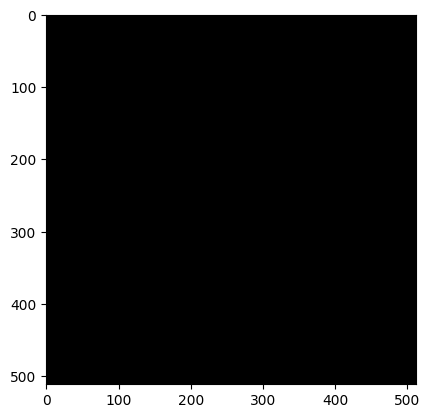

In [16]:
colored_gt = np.stack((gt_vol[0],)*3, axis=-1)
print(colored_gt.shape)
plt.imshow(colored_gt)

In [17]:
tile_depth, tile_width, tile_height = 3, 512, 512

In [18]:
import copy
import tqdm
import torchio as tio
def assemble_predictions(images_dir, preds_dir, gt_dir, overlay=True):
    # superimpose the predictions on the image 
    red = (0, 0, 255) # FP
    green = (0, 255, 0) #TP
    blue = (255, 0, 0) #FN

    preds_colors = [green, red, blue]

    # magenta:
    # magenta = (255, 0, 255) #conf 5
    # cyan = (255, 255, 0) #conf 4
    # brown = (0, 255, 255) #conf 3
    # orange = (0, 165, 255) #conf 2
    # light_blue = (255, 165, 0) #conf 1
    conf5 = (255, 0, 255) #conf 5
    conf4 = (255, 255, 0) #conf 4
    conf3 = (0, 255, 255) #conf 3
    conf2 = (0, 165, 255) #conf 2
    conf1 = (255, 165, 0) #conf 1

    gt_colors = [conf1, conf2, conf3, conf4, conf5]
    end_s = 6
    end_y = 8192
    end_x = 9216
    start_y=0
    start_x=0
    total_slices = ((end_s//3) * ((end_y-start_y)//512 )* ((end_x-start_x)//512))
    slice_num = 0
    print(total_slices, "total slices")
    for s in range(0, end_s, 3):
        s_acc_img, s_acc_pred, s_acc_gt = [], [], []
        for y in range(start_y, end_y, 512):
            y_acc_img, y_acc_pred, y_acc_gt = [], [], []
            for x in range(start_x, end_x, 512):
                print(f"Processing volume {s,y,x} | Progress:{slice_num+1}/{total_slices} {(slice_num)/total_slices}", end="\r")
                suffix = r"z{}_y{}_x{}".format(s, y, x)
                
                # load img
                try:
                    img_vol = np.load(os.path.join(images_dir, f"{suffix}.npy"))
                except:
                    img_vol = np.zeros((3, 512,512))
                    print("no img")
                d, h, w = img_vol.shape
                if (d < tile_depth) or (h < tile_height) or (w < tile_width):
                    print("cropping since imgvol shape:", img_vol.shape)
                    img_vol = tio.CropOrPad((tile_depth, tile_height, tile_width))(torch.tensor(img_vol).unsqueeze(0))
                
                # load gt
                try:
                    gt_vol = np.load(os.path.join(gt_dir, f"{suffix}.npy"))
                except:
                    gt_vol = np.zeros((3,512,512))
                    print("no gt")
                if (d < tile_depth) or (h < tile_height) or (w< tile_width):
                    gt_vol = tio.CropOrPad((tile_depth, tile_height, tile_width))(gt_vol)
                
                # load pred
                try:
                    pred_vol = np.load(os.path.join(preds_dir, f"{suffix}.npy"))
                    pred_vol = np.argmax(pred_vol[0], 0) 
                except:
                    print("no pred vol")
                    pred_vol = np.zeros((3, 512,512))
                if (d < tile_depth) or (h < tile_height) or (w < tile_width):
                    pred_vol = tio.CropOrPad((tile_depth, tile_height, tile_width))(pred_vol)
                    
                small_3d_img = []
                small_3d_pred = []
                small_3d_gt = []
                for k in range(3):
                    img = img_vol[k]
                    gt = gt_vol[k]
                    pred = pred_vol[k]
                    small_3d_img += [img]
                    small_3d_gt += [gt]
                    small_3d_pred += [pred]
                    
                small_3d_pred = np.array(small_3d_pred)
                small_3d_gt = np.array(small_3d_gt)
                small_3d_img = np.array(small_3d_img)
                    
                y_acc_gt += [small_3d_gt]
                y_acc_img += [small_3d_img]
                y_acc_pred += [small_3d_pred]
                slice_num+=1
            print(f"Processing volume {s,y,x} | Progress:{slice_num+1}/{total_slices} {(slice_num)/total_slices}")
            s_acc_img += [np.concatenate(y_acc_img, axis=2)]
            s_acc_pred += [np.concatenate(y_acc_pred, axis=2)]
            s_acc_gt += [np.concatenate(y_acc_gt, axis=2)]

        new_img = np.concatenate(s_acc_img, axis=1)
        new_pred = np.concatenate(s_acc_pred, axis=1)
        new_gt = np.concatenate(s_acc_gt, axis=1)
        
        return new_img, new_pred, new_gt

In [19]:
from tqdm import tqdm 
new_img, new_pred, new_gt = assemble_predictions(img_dir, pred_dir, gt_dir)
print("shape", new_img.shape, new_pred.shape, new_gt.shape)

576 total slices
Processing volume (0, 0, 8704) | Progress:19/576 0.031253888888888888
Processing volume (0, 512, 8704) | Progress:37/576 0.062563888888888896
Processing volume (0, 1024, 8704) | Progress:55/576 0.09375388888888898
Processing volume (0, 1536, 8704) | Progress:73/576 0.12526388888888898
Processing volume (0, 2048, 8704) | Progress:91/576 0.15625388888888896
Processing volume (0, 2560, 8704) | Progress:109/576 0.18756388888888896
Processing volume (0, 3072, 8704) | Progress:127/576 0.21875388888888896
Processing volume (0, 3584, 8704) | Progress:145/576 0.25826388888888896
Processing volume (0, 4096, 8704) | Progress:163/576 0.2812538888888889
Processing volume (0, 4608, 8704) | Progress:181/576 0.3125638888888889
no imgsing volume (0, 5120, 0) | Progress:181/576 0.3125
no gt
no pred vol
no imgsing volume (0, 5120, 512) | Progress:182/576 0.3142361111111111
no gt
no pred vol
no imgsing volume (0, 5120, 1024) | Progress:183/576 0.3159722222222222
no gt
no pred vol
no imgsi

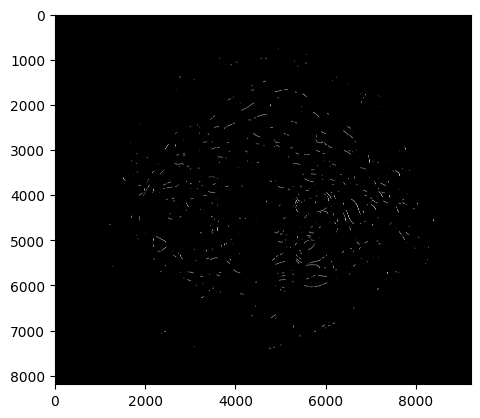

In [8]:
plt.imshow(new_pred[0], cmap="gray")

In [20]:
binary_gt = new_gt.copy()
binary_gt[binary_gt != 0] = 1
print(np.unique(binary_gt, return_counts=True))

(array([0., 1.]), array([225648366,    844050]))


In [22]:
# save separate
save_dir = "/Volumes/LaCie/gapjnc92/"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
if not os.path.isdir(save_dir):
    os.mkdir(save_dir)
print(new_img.shape, new_pred.shape, new_gt.shape)
for k in range(6):
    cv2.imwrite(save_dir + suffix + f"_img_slice{k}.png", new_img[k])
    plt.imsave(save_dir + suffix + f"_pred_slice{k}.png", new_pred[k], cmap="gray")
    plt.imsave(save_dir + suffix + f"_gt_slice{k}.png", new_gt[k], cmap="gray")
    print(f"Saved slice {k}")

(3, 8192, 9216) (3, 8192, 9216) (3, 8192, 9216)
Saved slice 0
Saved slice 1
Saved slice 2


IndexError: index 3 is out of bounds for axis 0 with size 3

In [26]:
def get_colored_image(image, color_map=None):
    # Define the default color map
    if color_map is None:
        color_map = {
            0: [0, 0, 0],  # Black (TN)
            1: [1, 0, 0],  # Red (FP) (pred only)
            2: [0, 0, 1],  # Blue (FN) (double_mask only)
            3: [0, 1, 0],  # Green (TP)
        }
    # Create an empty RGB image
    depth, height, width = image.shape[0], image.shape[1], image.shape[2]
    colored_image = np.zeros((depth, height, width, 3), dtype=np.float32) 
    
    # Map the pixel values to the corresponding colors
    for value, color in color_map.items():
        colored_image[image == value] = color
    return colored_image

In [27]:
combined_volume = np.asarray((binary_gt[1] * 2 + new_pred))
color_combined_volume = get_colored_image(combined_volume)
print(np.unique(combined_volume, return_counts=True))

(array([0., 1., 2., 3.]), array([225387173,    256744,    657195,    191304]))


In [25]:
# save separate
save_dir = "/Volumes/LaCie/gapjnc92/combined_two"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
for k in range(3):
    plt.imsave(save_dir + suffix + f"_comb_slice{k}.png", color_combined_volume[k], cmap="gray")
    print(f"Saved slice {k}")

Saved slice 0
Saved slice 1
Saved slice 2


IndexError: index 3 is out of bounds for axis 0 with size 3

In [12]:
color_combined_volume.shape

(3, 8192, 9216, 3)

In [28]:
# save combined
save_dir = "/Volumes/LaCie/gapjnc92/combined_two/"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
if not os.path.isdir(save_dir):
    os.mkdir(save_dir)
use_lines = False
alpha = 0.4
yellow = [255, 255, 0]
line_width = 3
height, width = new_img.shape[1], new_img.shape[2]
for k in range(3):
    print(f"Saved {k}")
    fig = plt.figure(num=1)
    if use_lines:
        lined_img = new_img[k].copy()
        lined_img = (lined_img - np.min(lined_img))/(np.max(lined_img)-np.min(lined_img))
        lined_img = np.stack((lined_img,) * 3, axis=-1)

        for y in range(0, height, 512):
            lined_img[y:y+line_width, :] = yellow
        for x in range(0, width, 512):
            lined_img[:, x:x+line_width] = yellow
        plt.imshow(lined_img)
    else:
        plt.imshow(new_img[k], cmap='gray')
    plt.imshow(color_combined_volume[k], alpha=alpha)
    plt.savefig(save_dir + f"tmp{k}.png", dpi=800)
    plt.close("all")

Saved 0
Saved 1
Saved 2


In [34]:
# save combined
save_dir = "/Volumes/LaCie/gapjnc16/combined/"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
if not os.path.isdir(save_dir):
    os.mkdir(save_dir)
use_lines = True
alpha = 0.4
yellow = [255, 255, 0]
line_width = 3
height, width = new_img.shape[1], new_img.shape[2]
for k in range(3):
    print(f"Saved {k}")
    fig = plt.figure(num=1)
    if use_lines:
        lined_img = new_img[k].copy()
        lined_img = (lined_img - np.min(lined_img))/(np.max(lined_img)-np.min(lined_img))
        lined_img = np.stack((lined_img,) * 3, axis=-1)

        for y in range(0, height, 512):
            lined_img[y:y+line_width, :] = yellow
        for x in range(0, width, 512):
            lined_img[:, x:x+line_width] = yellow
        plt.imshow(lined_img)
    else:
        plt.imshow(new_img[k], cmap='gray')
    plt.imshow(color_combined_volume[k], alpha=alpha)
    plt.savefig(save_dir + f"tmp{k}.png", dpi=800)
    plt.close("all")

Saved 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved 1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


: 